**Task 1, 2 and 3**

In [1]:
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torchvision.models as models

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [2]:
class Net(nn.Module):
        def __init__(self):
                super(Net, self).__init__()
                self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
                self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
                self.conv3 = nn.Conv2d(32,64, kernel_size=5)
                self.fc1 = nn.Linear(3*3*64, 256)
                self.fc2 = nn.Linear(256, 10)

        def feature(self,x):
                x = F.relu(self.conv1(x))
                x = F.relu(F.max_pool2d(self.conv2(x), 2))
                x = F.dropout(x, p=0.5, training=self.training)
                x = F.relu(F.max_pool2d(self.conv3(x),2))
                x = F.dropout(x, p=0.5, training=self.training)
                x = x.view(x.size(0), -1)
                return x
                
        def forward(self, x):
                x = self.feature(x)
                x = F.relu(self.fc1(x))
                x = F.dropout(x, training=self.training)
                x = self.fc2(x)
                return F.log_softmax(x, dim=1)

model = Net()

In [3]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):

    train_losses = []
    valid_losses = []
    best_model_loss = 5
    
    for epoch in range(num_epochs):

        # Training
        model.train()
        for i, (data, labels) in enumerate(train_loader):
      
            prediction = model(data)

            train_loss = criterion(prediction, labels)

            train_loss.backward()

            optimizer.step()

            optimizer.zero_grad()
        print(f'\rEpoch {epoch+1}, batch {i+1}/{len(train_loader)} - Loss: {train_loss}')

        train_losses.append(train_loss)
        writer.add_scalar("Loss/train ADAM", train_loss, epoch)

        # Validation
        model.eval()
        for batch_nr, (data, labels) in enumerate(val_loader):
            prediction = model.forward(data)
            loss_val = criterion(prediction, labels)
            valid_losses.append(loss_val)
        print(f"loss validation: {loss_val}")

        if valid_losses[-1] < best_model_loss:
            print(f"\t > Found a better model, {best_model_loss} -> {valid_losses[-1]}")
            best_model = copy.deepcopy(model)
            best_model_loss = valid_losses[-1]

        writer.add_scalar("Loss/validation ADAM", loss_val, epoch)

    print(f"\nBest model loss: {best_model_loss}")
    return best_model, train_losses, valid_losses

def get_accuracy(network, loader):
    
    with torch.no_grad():
        correct = 0
        total = 0
        y_pred = []
        y_true = []

        for x, (data, labels) in enumerate(loader):

            prediction = network.forward(data)

            for i in range(len(data)):

                y_true.append(labels[i].item())
                y_pred.append(torch.argmax(prediction[i]).item())
                if y_true[i] == y_pred[i]:
                    correct += 1        
    
            total += float(len(data))
    
        score = correct/total

        accuracy = score

        return accuracy

In [4]:
LEARNING_RATE = 1e-6
EPOCHS = 1
BATCH_SIZE = 1000

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)

validset, trainset = torch.utils.data.random_split(trainset, [10000, 50000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-5)

# Train the model
trained_model, train_loss, valid_loss = train_model(model, criterion, optimizer, trainloader, validloader, EPOCHS)

# Test the model
test_acc = get_accuracy(trained_model, testloader)
print(f"Model Accuracy (MNIST): {test_acc*100}%")
writer.flush()

Epoch 1, batch 50/50 - Loss: 2.304689884185791
loss validation: 2.301565170288086
	 > Found a better model, 5 -> 2.301565170288086

Best model loss: 2.301565170288086
Model Accuracy (MNIST): 9.4%


In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

[Text(0.5, 1.0, 'MNIST data t-SNE projection')]

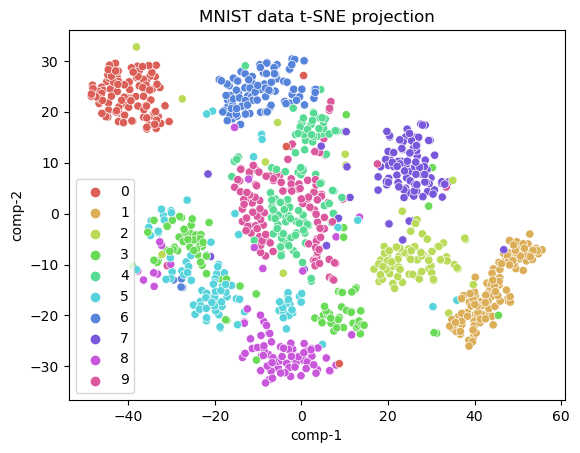

In [6]:
images, labels = next(iter(trainloader))
f = trained_model.feature(images)

tsne = TSNE(n_components=2,random_state=123)
z = tsne.fit_transform(f.detach().numpy())
df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1",y="comp-2",hue=df.y.tolist(), 
                palette= sns.color_palette("hls",10), 
                data=df).set(title="MNIST data t-SNE projection")

[Text(0.5, 1.0, 'MNIST data PCA projection')]

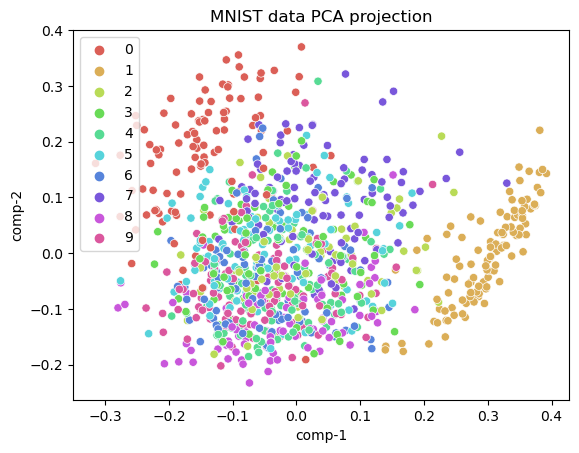

In [7]:
pca = PCA(n_components=2)
p = pca.fit_transform(f.detach().numpy())

df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = p[:,0]
df["comp-2"] = p[:,1]

sns.scatterplot(x="comp-1",y="comp-2",hue=df.y.tolist(), 
                palette= sns.color_palette("hls",10), 
                data=df).set(title="MNIST data PCA projection")

**Task 4, 5**

In [8]:
LEARNING_RATE = 1e-3
EPOCHS = 10
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-5)

# Train the model
trained_model, train_loss, valid_loss = train_model(model, criterion, optimizer, trainloader, validloader, EPOCHS)

# Test the model
test_acc = get_accuracy(trained_model, testloader)
print(f"Model Accuracy (MNIST): {test_acc*100}%")
writer.flush()

Epoch 1, batch 50/50 - Loss: 0.3593152165412903
loss validation: 0.17377983033657074
	 > Found a better model, 5 -> 0.17377983033657074
Epoch 2, batch 50/50 - Loss: 0.1670692414045334
loss validation: 0.09495124220848083
	 > Found a better model, 0.17377983033657074 -> 0.09495124220848083
Epoch 3, batch 50/50 - Loss: 0.13215385377407074
loss validation: 0.08608792722225189
	 > Found a better model, 0.09495124220848083 -> 0.08608792722225189
Epoch 4, batch 50/50 - Loss: 0.13448312878608704
loss validation: 0.05998662859201431
	 > Found a better model, 0.08608792722225189 -> 0.05998662859201431
Epoch 5, batch 50/50 - Loss: 0.09478401392698288
loss validation: 0.05830949917435646
	 > Found a better model, 0.05998662859201431 -> 0.05830949917435646
Epoch 6, batch 50/50 - Loss: 0.09085105359554291
loss validation: 0.0597667470574379
Epoch 7, batch 50/50 - Loss: 0.08273541182279587
loss validation: 0.04165345057845116
	 > Found a better model, 0.05830949917435646 -> 0.04165345057845116
Epoch

[Text(0.5, 1.0, 'MNIST data t-SNE projection')]

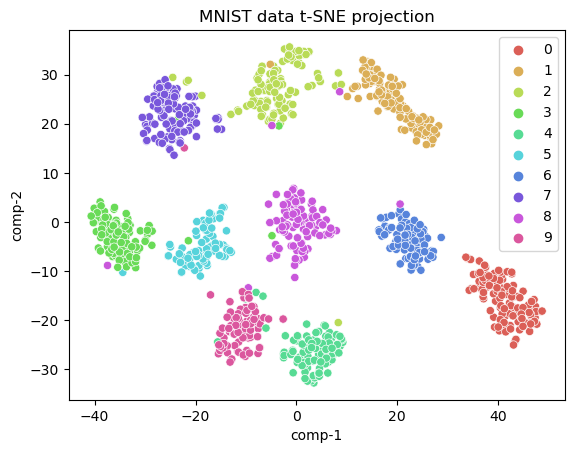

In [9]:
images, labels = next(iter(trainloader))
f = trained_model.feature(images)

tsne = TSNE(n_components=2,random_state=123)
z = tsne.fit_transform(f.detach().numpy())
df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1",y="comp-2",hue=df.y.tolist(), 
                palette= sns.color_palette("hls",10), 
                data=df).set(title="MNIST data t-SNE projection")

[Text(0.5, 1.0, 'MNIST data PCA projection')]

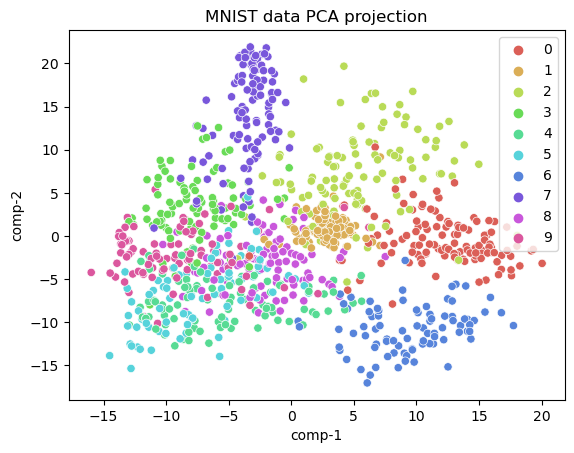

In [10]:
pca = PCA(n_components=2)
p = pca.fit_transform(f.detach().numpy())

df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = p[:,0]
df["comp-2"] = p[:,1]

sns.scatterplot(x="comp-1",y="comp-2",hue=df.y.tolist(), 
                palette= sns.color_palette("hls",10), 
                data=df).set(title="MNIST data PCA projection")

**Task 6**

a) From the scatter plot graphs, performance of t-SNE is better than PCA as it preserves global structures as well as local structures. It is also able to easily separate different classes as compared to PCA.

b) Even though well-trained model performs better than non-trained, the result was still acceptable for t-SNE projection. For PCA, training is required for a useful result. Non-trained PCA is not good enough for any class separation, except separating the 1's.